# NMMA Retreat: Machine Learning Activities

## This notebook contains code that describes the ML techniques that NMMA uses for EM analyses based on model light curve grids. These techniques involve:
- ### Unsupervised learning: dimensionality reduction
  - Light curves are mapped to a set of eigenvalues using a Singular Value Decomposition (SVD). This reduces the dimensionality of the light curves to 10 (by default). By inverting the process, light curves can be constructed from a set of eigenvalues. Establishing a reliable mapping between physical parameters and eigenvalues will enable interpolation of a model light curve grid.   
- ### Supervised learning: regression
  - This notebook focuses on the use of a neural network (NN) to perform regression. The NN maps the physical parameters of a model grid to the light curve eigenvalues obtained via SVD. Once this mapping is learned, light curves can be constructed using any combination of physical parameters, rather than the grid points only. The NN accelerates a process that can also be performed using a Gaussian Process (GP).

## Instructions:
- Make sure you have nmma installed and up-to-date (see https://nuclear-multimessenger-astronomy.github.io/nmma/)
- Activate your nmma environment (e.g. `conda activate nmma_env`) before continuing
- Download and unzip the Bu2022Ye light curve grid from Google Drive at the link provided, making sure it's in the `nmma-retreat` directory

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import os
import numpy as np

from nmma.em.training import SVDTrainingModel
from nmma.em.model import SVDLightCurveModel
from nmma.em.utils import calc_lc, interpolate_nans
from scipy.interpolate import interp1d

from nmma.em.io import read_photometry_files
import glob
import inspect
from nmma.em import model_parameters
from tensorflow.keras.models import load_model


tf.get_logger().setLevel("ERROR")

## Run training after downloading Bu2022Ye grid, benchmark results
Initially, we will run NMMA NN training as if we were using the command line interface. We will follow this up with an exploration into the code behind the process.

In [9]:
os.system("create-svdmodel --model Bu2022Ye --svd-path svdmodels --interpolation-type tensorflow --tmin 0. --tmax 21.0 --dt 0.1 --data-path lcs_Bu2022Ye --tensorflow-nepochs 100 --outdir outdir --plot --filters ztfg,ztfr,ztfi")
# (Can also be run direcly in command line)

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Traceback (most recent call last):
  File "/home/tbarna/anaconda3/envs/nmma_env/bin/create-svdmodel", line 8, in <module>
    sys.exit(main())
  File "/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/nmma/em/create_svdmodel.py", line 214, in main
    raise ValueError("Need at least one file to interpolate.")
ValueError: Need at least one file to interpolate.


256

In [3]:
os.system("svdmodel-benchmark --model Bu2022Ye --svd-path svdmodels --interpolation-type tensorflow --tmin 0. --tmax 21.0 --dt 0.1 --data-path lcs_Bu2022Ye --outdir benchmarks --filters ztfg,ztfr,ztfi")
# (Can also be run direcly in command line)

Loaded filter ztfg
Loaded filter ztfr
Loaded filter ztfi
Benchmarking model Bu2022Ye on filter ['ztfg', 'ztfr', 'ztfi'] with 1 cpus


0

## Define initial variables, read grid, interpolate NaNs

In [4]:
# Set filter list, number of SVD coefficients, sample time array

# Use ZTF filters
filters = ["ztfg", "ztfr", "ztfi"]

# Same defaults as NMMA
n_coeff = 10 
sample_times = np.arange(0,21.1,0.1)

In [5]:
# glob all model files

filenames = glob.glob(f"lcs_Bu2022Ye/*.dat")
len(filenames)

11264

In [6]:
# read photometric data

data = read_photometry_files(filenames, datatype="bulla")

In [7]:
# interpolate nan values

data = interpolate_nans(data)

In [8]:
# using Bu2022Ye specifics, map input to data dictionary + list of parameters
model = "Bu2022Ye"
MODEL_FUNCTIONS = {
        k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
    }

training_data, parameters = MODEL_FUNCTIONS[model](data)

In [9]:
type(training_data), len(training_data)

(dict, 11264)

In [10]:
parameters

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']

### Select first entry in the grid to use for plotting later

In [11]:
key = [x for x in training_data.keys()][0]
key

'nph1.0e+06_dyn0.010-0.25-0.25_wind0.130-0.05_theta45.57_dMpc0'

In [12]:
# look at data associated with one parameter combo in grid

example_training_data = training_data[key]
example_training_data.keys()

dict_keys(['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta', 't', 'bessellux', 'bessellb', 'bessellv', 'bessellr', 'besselli', 'sdssu', 'ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', 'uvot__b', 'uvot__u', 'uvot__uvm2', 'uvot__uvw1', 'uvot__uvw2', 'uvot__v', 'uvot__white', 'atlasc', 'atlaso', '2massj', '2massh', '2massks', 'ztfg', 'ztfr', 'ztfi'])

### Plot a light curve from the grid

Text(0, 0.5, 'Absolute ztfi')

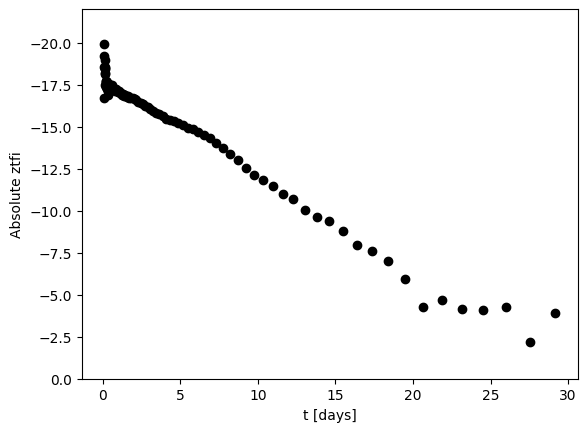

In [13]:
plt.scatter(example_training_data["t"], example_training_data["ztfi"], color='black')
plt.ylim(0,-22)
plt.xlabel("t [days]")
plt.ylabel("Absolute ztfi")


## Interpolate grid data onto `sample_times` points

In [14]:
# code from nmma.em.training:SVDTrainingModel.interpolate_data

magkeys = training_data.keys()
time_scale_factor = 1.0

for jj, key in enumerate(magkeys):

    # Interpolate data onto grid
    training_data[key]["data"] = np.zeros(
        (len(sample_times), len(filters))
    )
    for jj, filt in enumerate(filters):
        ii = np.where(np.isfinite(training_data[key][filt]))[0]
        if len(ii) < 2:
            continue

        f = interp1d(
            training_data[key]["t"][ii] / time_scale_factor,
            training_data[key][filt][ii],
            fill_value="extrapolate",
        )
        maginterp = f(sample_times)
        training_data[key]["data"][:, jj] = maginterp

## Generate SVD model using `numpy.linalg.svd`

In [15]:
# code from nmma.em.training:SVDTrainingModel.generate_svd_model

model_keys = list(training_data.keys())

# Place the relevant parameters into an array
param_array = []
for key in model_keys:
    param_array.append(
        [training_data[key][param] for param in parameters]
    )
param_array_postprocess = np.array(param_array)

# normalize parameters
param_mins, param_maxs = np.min(param_array_postprocess, axis=0), np.max(
    param_array_postprocess, axis=0
)
for i in range(len(param_mins)):
    param_array_postprocess[:, i] = (
        param_array_postprocess[:, i] - param_mins[i]
    ) / (param_maxs[i] - param_mins[i])

# Output is data with keys being filters, and values being dictionaries for the SVD decomposition
svd_model = {}
# Loop through filters
for jj, filt in enumerate(filters):
    print("Normalizing mag filter %s..." % filt)
    data_array = []
    for key in model_keys:
        data_array.append(training_data[key]["data"][:, jj])

    data_array_postprocess = np.array(data_array)
    mins, maxs = np.min(data_array_postprocess, axis=0), np.max(
        data_array_postprocess, axis=0
    )
    for i in range(len(mins)):
        data_array_postprocess[:, i] = (
            data_array_postprocess[:, i] - mins[i]
        ) / (maxs[i] - mins[i])
    data_array_postprocess[np.isnan(data_array_postprocess)] = 0.0

    svd_model[filt] = {}
    svd_model[filt]["param_array_postprocess"] = param_array_postprocess
    svd_model[filt]["param_mins"] = param_mins
    svd_model[filt]["param_maxs"] = param_maxs
    svd_model[filt]["mins"] = mins
    svd_model[filt]["maxs"] = maxs
    svd_model[filt]["tt"] = sample_times
    # Add one more key for notebook example
    svd_model[filt]["data_array_example"] = data_array[0]

    # Perform the SVD decomposition
    UA, sA, VA = np.linalg.svd(data_array_postprocess, full_matrices=True)
    VA = VA.T

    n, n = UA.shape
    m, m = VA.shape

    cAmat = np.zeros((n_coeff, n))
    cAvar = np.zeros((n_coeff, n))
    for i in range(n):
        # Get the data matrix
        cAmat[:, i] = np.dot(
            data_array_postprocess[i, :], VA[:, : n_coeff]
        )
        # Get variance matrix
        ErrorLevel = 1.0
        errors = ErrorLevel * np.ones_like(data_array_postprocess[i, :])
        cAvar[:, i] = np.diag(
            np.dot(
                VA[:, : n_coeff].T,
                np.dot(np.diag(np.power(errors, 2.0)), VA[:, : n_coeff]),
            )
        )
    cAstd = np.sqrt(cAvar)

    svd_model[filt]["n_coeff"] = n_coeff
    svd_model[filt]["cAmat"] = cAmat
    svd_model[filt]["cAstd"] = cAstd
    svd_model[filt]["VA"] = VA

Normalizing mag filter ztfg...
Normalizing mag filter ztfr...
Normalizing mag filter ztfi...


In [16]:
# look at keys associated with one filter in svd_model

svd_model[filt].keys()

dict_keys(['param_array_postprocess', 'param_mins', 'param_maxs', 'mins', 'maxs', 'tt', 'data_array_example', 'n_coeff', 'cAmat', 'cAstd', 'VA'])

### Plot a grid light curve, its interpolation, and a reconstructed version using 10 SVD coefficients

In [19]:
filt = "ztfi"

reconstructed_mag_back = np.dot(svd_model[filt]["VA"][:, :n_coeff], svd_model[filt]["cAmat"][:,0])
reconstructed_mag_back = reconstructed_mag_back * (svd_model[filt]["maxs"] - svd_model[filt]["mins"]) + svd_model[filt]["mins"]

ii = np.where((~np.isnan(reconstructed_mag_back)) * (svd_model[filt]["tt"] < 20.0))[0]
if len(ii) < 2:
    reconmaginterp = np.nan * np.ones(tt.shape)
else:
    f = interp1d(svd_model[filt]["tt"][ii], reconstructed_mag_back[ii], fill_value="extrapolate")
    reconmaginterp = f(svd_model[filt]["tt"])


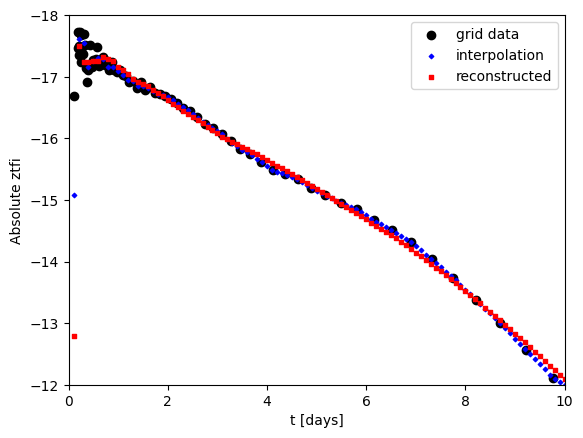

In [20]:
plt.scatter(example_training_data["t"], example_training_data[filt], color='black', label="grid data")
plt.scatter(sample_times, svd_model[filt]["data_array_example"], color='blue', marker='D', s=5, label="interpolation")
plt.scatter(sample_times, reconmaginterp, color='red', marker='s', s=5, label="reconstructed")
plt.ylim(-12,-18)
plt.xlim(0,10)

plt.xlabel("t [days]")
plt.ylabel(f"Absolute {filt}")
plt.legend()

### Plot a post-processed grid light curve

Text(0, 0.5, 'Post-processed ztfi data')

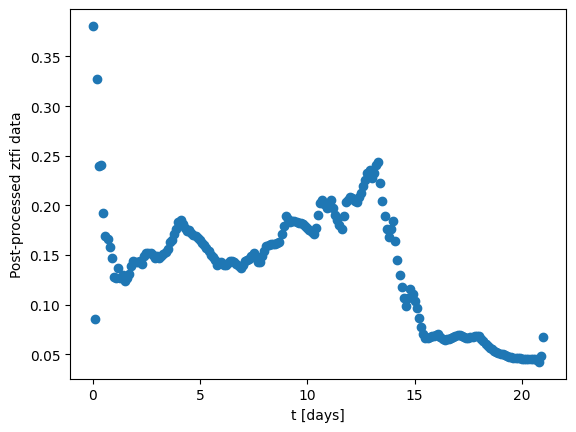

In [21]:
# Absolute magnitudes scaled by whole-grid min/max values at each time point
plt.scatter(sample_times, data_array_postprocess[0,:])
plt.xlabel("t [days]")
plt.ylabel(f"Post-processed {filt} data")

### Examine results from SVD

In [22]:
# Unitary array(s). The first a.ndim - 2 dimensions have the same size as those of the input a.
# The size of the last two dimensions depends on the value of full_matrices. Only returned when compute_uv is True.

UA.shape

(11264, 11264)

In [23]:
# Vector(s) with the singular values, within each vector sorted in descending order.
# The first a.ndim - 2 dimensions have the same size as those of the input a.

sA.shape

(211,)

In [24]:
# Unitary array(s). The first a.ndim - 2 dimensions have the same size as those of the input a.
# The size of the last two dimensions depends on the value of full_matrices. Only returned when compute_uv is True.

VA.shape

(211, 211)

In [25]:
# for i in range(n):
    # cAmat[:, i] = np.dot(
    #     data_array_postprocess[i, :], VA[:, : n_coeff]
    # )

cAmat.shape

(10, 11264)

In [26]:
param_array_postprocess[0]

array([0.76862179, 1.        , 0.66666667, 1.        , 0.16666667,
       0.50633333])

## Reconstruct light curves

In [27]:
param_array_postprocess[0]

array([0.76862179, 1.        , 0.66666667, 1.        , 0.16666667,
       0.50633333])

In [28]:
# code from nmma.em.utils.calc_lc

mAB = {}

for jj, filt in enumerate(filters):
    if filt in mAB:
        continue

    n_coeff = svd_model[filt]["n_coeff"]
    VA = svd_model[filt]["VA"]
    param_mins = svd_model[filt]["param_mins"]
    param_maxs = svd_model[filt]["param_maxs"]
    mins = svd_model[filt]["mins"]
    maxs = svd_model[filt]["maxs"]
    tt_interp = svd_model[filt]["tt"]
    tt = sample_times

    param_list_postprocess =  [example_training_data[x] for x in parameters]
    for i in range(len(param_mins)):
        param_list_postprocess[i] = (param_list_postprocess[i] - param_mins[i]) / (
            param_maxs[i] - param_mins[i]
        )

    saved_model = load_model(f"svdmodels/Bu2022Ye_tf/{filt}.h5") #(replaced svd_mag_model[filt]["model"] for this notebook)
    cAproj = saved_model(np.atleast_2d(param_list_postprocess)).numpy().T.flatten()
    cAstd = np.ones((n_coeff,))

    mag_back = np.dot(VA[:, :n_coeff], cAproj)
    mag_back = mag_back * (maxs - mins) + mins

    ii = np.where((~np.isnan(mag_back)) * (tt_interp < 20.0))[0]
    if len(ii) < 2:
        maginterp = np.nan * np.ones(tt.shape)
    else:
        f = interp1d(tt_interp[ii], mag_back[ii], fill_value="extrapolate")
        maginterp = f(tt)
    mAB[filt] = maginterp

In [29]:
param_array[0]

[-2.0, 0.25, 0.25, -0.8860566476931632, 0.05, 45.57]

In [30]:
param_list_postprocess

[0.7686217868402407,
 1.0,
 0.6666666666666667,
 1.0,
 0.1666666666666667,
 0.5063333333333333]

In [31]:
VA[:, :n_coeff].shape

(211, 10)

In [32]:
cAproj.shape

(10,)

## Plot light curves from saved model

Text(0, 0.5, 'Absolute ztfg')

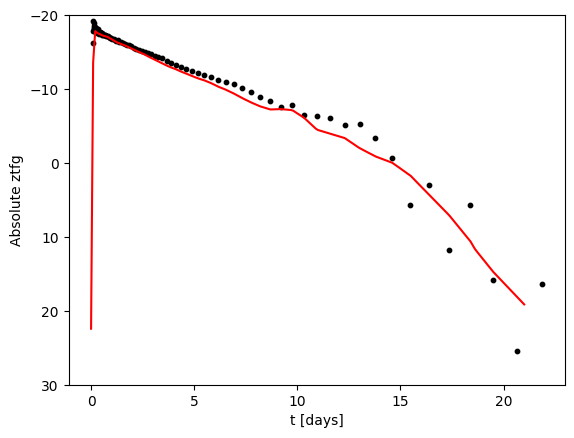

In [33]:
plt.scatter(example_training_data["t"], example_training_data["ztfg"],s=10, color='black')
plt.plot(tt, mAB["ztfg"], color='red')
plt.ylim(30,-20)
plt.xlabel("t [days]")
plt.ylabel("Absolute ztfg")

Text(0, 0.5, 'Absolute ztfr')

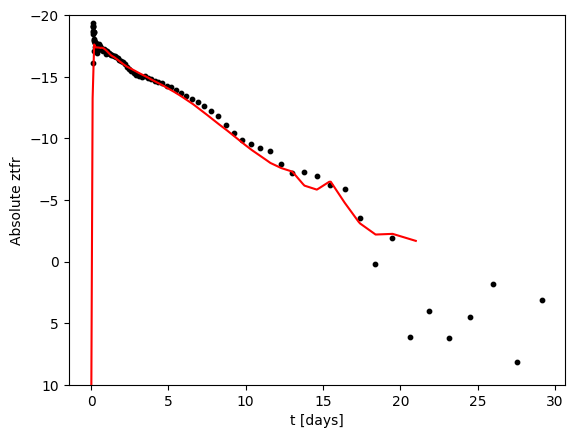

In [34]:
plt.scatter(example_training_data["t"], example_training_data["ztfr"],s=10, color='black')
plt.plot(tt, mAB["ztfr"], color='red')
plt.ylim(10,-20)
plt.xlabel("t [days]")
plt.ylabel("Absolute ztfr")

Text(0, 0.5, 'Absolute ztfi')

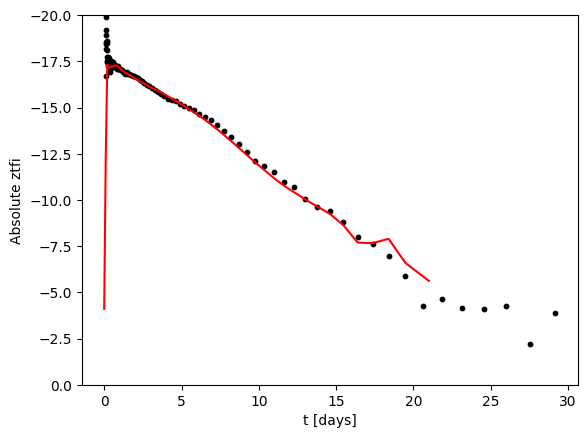

In [35]:
plt.scatter(example_training_data["t"], example_training_data["ztfi"],s=10, color='black')
plt.plot(tt, mAB["ztfi"], color='red')
plt.ylim(0,-20)
plt.xlabel("t [days]")
plt.ylabel("Absolute ztfi")

In [36]:
svd_model = joblib.load("svdmodels/Bu2022Ye.joblib")

random_seed = 42
dropout_rate = 0.6
n_epochs = 100

In [37]:
# Loop through filters
#for jj, filt in enumerate(filters):
#print("Computing NN for filter %s..." % filt)
filt = "ztfi"

param_array_postprocess = svd_model[filt]["param_array_postprocess"]
cAmat = svd_model[filt]["cAmat"]

train_X, val_X, train_y, val_y = train_test_split(
    param_array_postprocess,
    cAmat.T,
    shuffle=True,
    test_size=0.1,
    random_state=random_seed,
)

tf.keras.utils.set_random_seed(random_seed)

In [38]:
param_array_postprocess.shape

(11264, 6)

In [39]:
cAmat.T.shape

(11264, 10)

In [40]:
param_array_postprocess[0]

array([0.76862179, 1.        , 0.66666667, 1.        , 0.16666667,
       0.50633333])

In [41]:
parameters

['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']

## Visualize pre-processed params, light curve eigenvalues 

The panels generated below show the range of eigenvalue (cAmat.T) values for different parameter combinations. While some trends are visible, there is not an obvious distinction in any individual case. The nonlinear abilities of our NN regressor will help establish these relationships. 

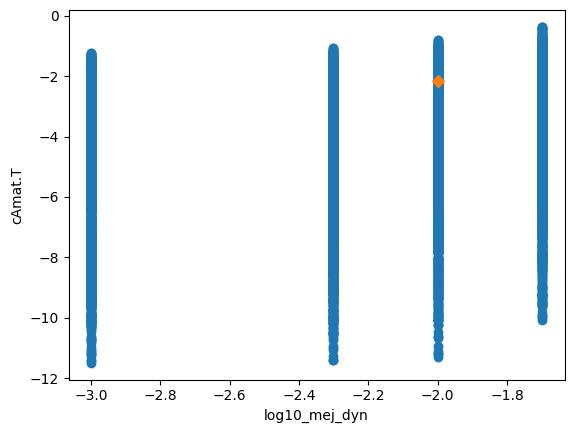

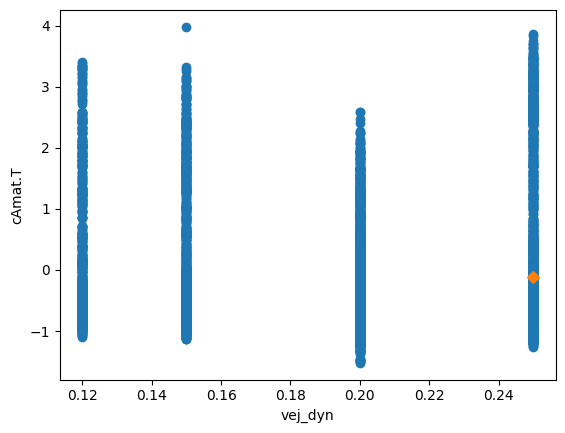

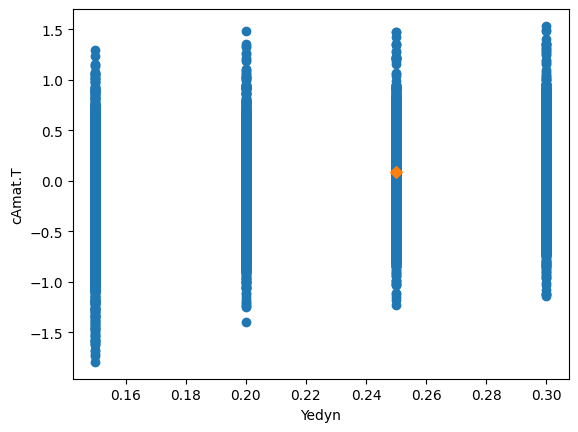

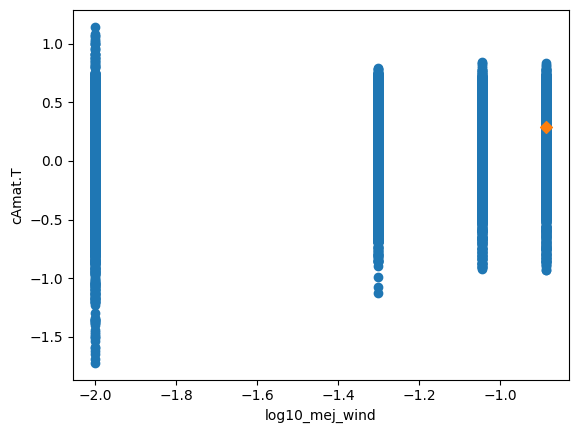

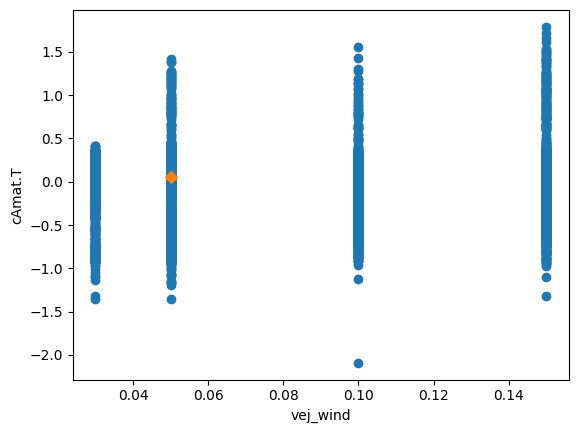

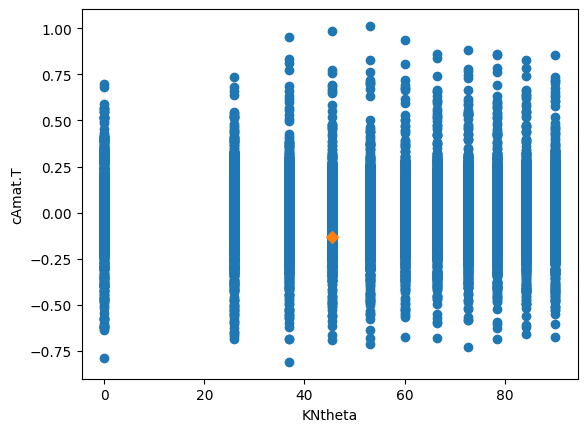

In [42]:
for i in range(6):
    plt.scatter(np.array(param_array)[:,i], cAmat.T[:,i])
    plt.scatter(np.array(param_array)[0,i], cAmat.T[0,i], marker='D')
    plt.xlabel(parameters[i])
    plt.ylabel("cAmat.T")
    plt.show()

## Set up, train and evaluate neural network

In [43]:
nn_model = Sequential()
# One/few layers of wide NN approximate GP
nn_model.add(
    Dense(
        2048,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(train_X.shape[1],),
    )
)
nn_model.add(Dropout(dropout_rate))
nn_model.add(Dense(n_coeff))

# compile the model
nn_model.compile(optimizer="adam", loss="mse")

In [44]:
# fit the model
training_history = nn_model.fit(
    train_X,
    train_y,
    epochs=n_epochs,
    batch_size=32,
    validation_data=(val_X, val_y),
    verbose=True,
)

Epoch 1/100
317/317 [==============================] - 1s 1ms/step - loss: 0.7633 - val_loss: 0.1824
Epoch 2/100
317/317 [==============================] - 0s 1ms/step - loss: 0.2221 - val_loss: 0.1374
Epoch 3/100
317/317 [==============================] - 0s 1ms/step - loss: 0.1584 - val_loss: 0.1081
Epoch 4/100
317/317 [==============================] - 0s 1ms/step - loss: 0.1346 - val_loss: 0.0907
Epoch 5/100
317/317 [==============================] - 0s 1ms/step - loss: 0.1178 - val_loss: 0.0719
Epoch 6/100
317/317 [==============================] - 0s 1ms/step - loss: 0.1098 - val_loss: 0.0738
Epoch 7/100
317/317 [==============================] - 0s 1ms/step - loss: 0.1010 - val_loss: 0.0581
Epoch 8/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0949 - val_loss: 0.0529
Epoch 9/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0890 - val_loss: 0.0509
Epoch 10/100
317/317 [==============================] - 0s 1ms/step - loss: 0.0853 - val_lo

In [45]:
model_cAmat = training_history.model(param_array_postprocess)

model_cAmat.shape

TensorShape([11264, 10])

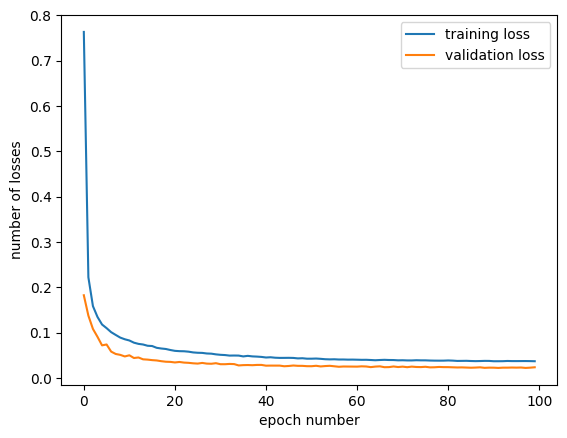

In [46]:
loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]

plt.figure()
plt.plot(loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.legend()
plt.xlabel("epoch number")
plt.ylabel("number of losses")
plt.show()

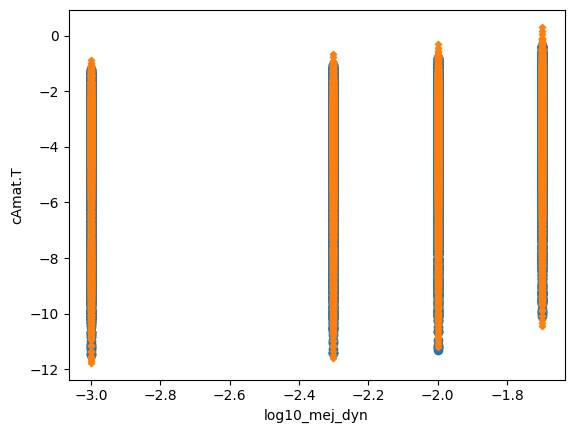

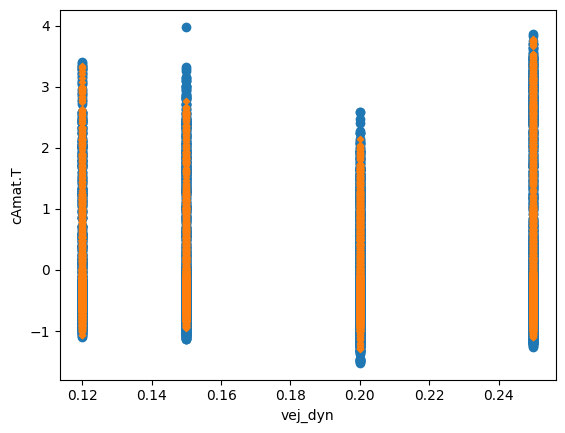

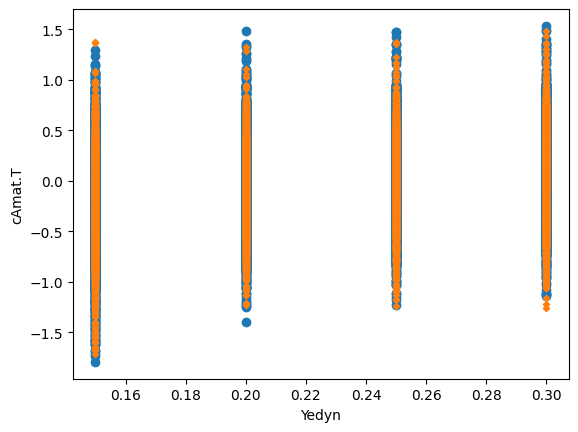

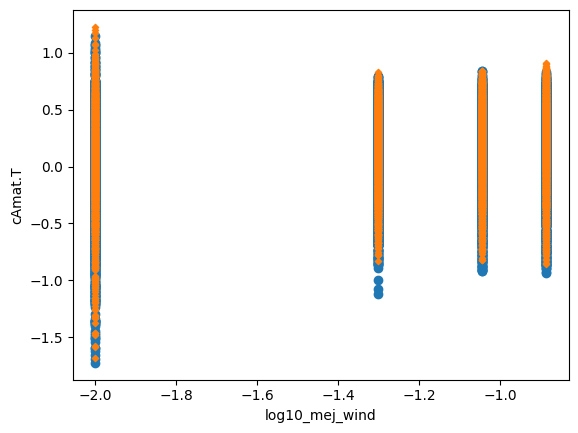

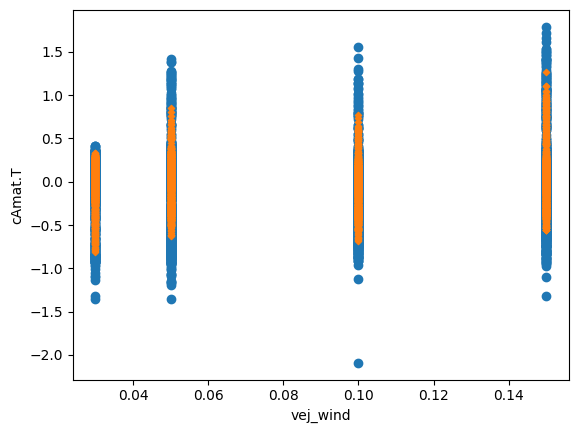

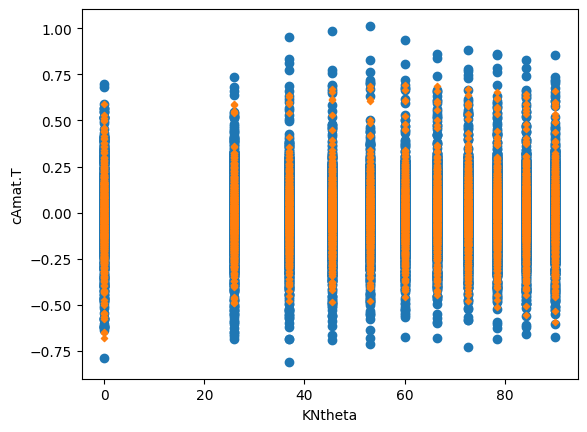

In [47]:
for i in range(6):
    plt.scatter(np.array(param_array)[:,i], cAmat.T[:,i])
    plt.scatter(np.array(param_array)[:,i], nn_model(np.atleast_2d(param_array_postprocess)).numpy().T[i, :], s=10, marker='D')
    plt.xlabel(parameters[i])
    plt.ylabel("cAmat.T")
    plt.show()

### Verify same results from current and saved training

In [48]:
saved_model(np.array([param_list_postprocess])) == nn_model(np.array([param_list_postprocess]))

<tf.Tensor: shape=(1, 10), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])>

### Calculate/plot magnitudes from the model we just trained

In [49]:
cAproj = nn_model(np.atleast_2d(param_list_postprocess)).numpy().T.flatten()
cAstd = np.ones((n_coeff,))

mag_back = np.dot(VA[:, :n_coeff], cAproj)

# undo processing from earlier
mag_back = mag_back * (maxs - mins) + mins

ii = np.where((~np.isnan(mag_back)) * (tt_interp < 20.0))[0]
if len(ii) < 2:
    maginterp = np.nan * np.ones(tt.shape)
else:
    f = interp1d(tt_interp[ii], mag_back[ii], fill_value="extrapolate")
    maginterp = f(tt)

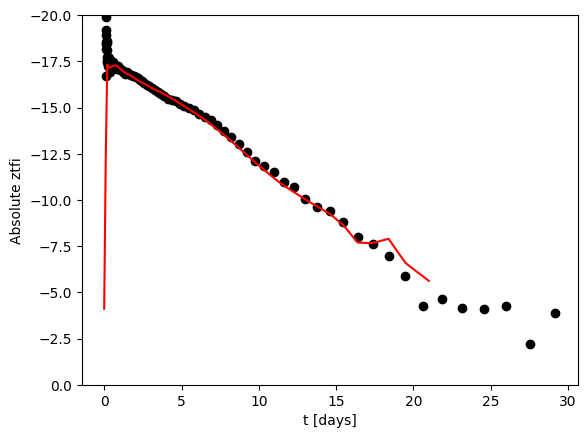

In [50]:
plt.scatter(example_training_data["t"], example_training_data["ztfi"], color='black')
plt.ylim(0, -20)
plt.xlabel("t [days]")
plt.ylabel(f"Absolute {filt}")

plt.plot(sample_times, maginterp, color='red') 

## Experiment: using light curve points as target values directly (no SVD)

In [51]:
alt_train_X, alt_val_X, alt_train_y, alt_val_y = train_test_split(
    param_array_postprocess,
    data_array_postprocess,
    shuffle=True,
    test_size=0.1,
    random_state=random_seed,
)

alt_nn_model = Sequential()
# One/few layers of wide NN approximate GP
alt_nn_model.add(
    Dense(
        2048,
        activation="relu",
        kernel_initializer="he_normal",
        input_shape=(alt_train_X.shape[1],),
    )
)
alt_nn_model.add(Dropout(dropout_rate))
alt_nn_model.add(Dense(alt_train_y.shape[1]))

# compile the model
alt_nn_model.compile(optimizer="adam", loss="mse")

In [52]:
# fit the model
alt_training_history = alt_nn_model.fit(
    alt_train_X,
    alt_train_y,
    epochs=n_epochs,
    batch_size=32,
    validation_data=(alt_val_X, alt_val_y),
    verbose=True,
)

Epoch 1/100
317/317 [==============================] - 1s 2ms/step - loss: 0.3425 - val_loss: 0.0135
Epoch 2/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0335 - val_loss: 0.0092
Epoch 3/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0063
Epoch 4/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0049
Epoch 5/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 6/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 7/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 8/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 9/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 10/100
317/317 [==============================] - 1s 2ms/step - loss: 0.0048 - val_lo

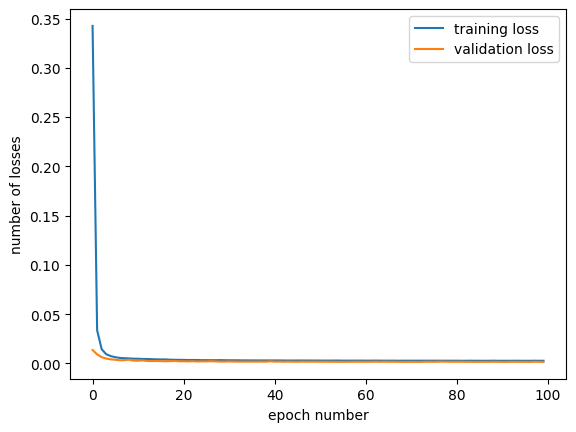

In [53]:
alt_loss = alt_training_history.history["loss"]
alt_val_loss = alt_training_history.history["val_loss"]

plt.figure()
plt.plot(alt_loss, label="training loss")
plt.plot(alt_val_loss, label="validation loss")
plt.legend()
plt.xlabel("epoch number")
plt.ylabel("number of losses")
plt.show()

In [54]:
alt_mag_back = alt_nn_model(np.atleast_2d(param_list_postprocess)).numpy().T.flatten()
alt_mag_back = alt_mag_back * (maxs - mins) + mins

ii = np.where((~np.isnan(alt_mag_back)) * (tt_interp < 20.0))[0]
if len(ii) < 2:
    altmaginterp = np.nan * np.ones(tt.shape)
else:
    f = interp1d(tt_interp[ii], alt_mag_back[ii], fill_value="extrapolate")
    altmaginterp = f(tt)

(0.0, 14.0)

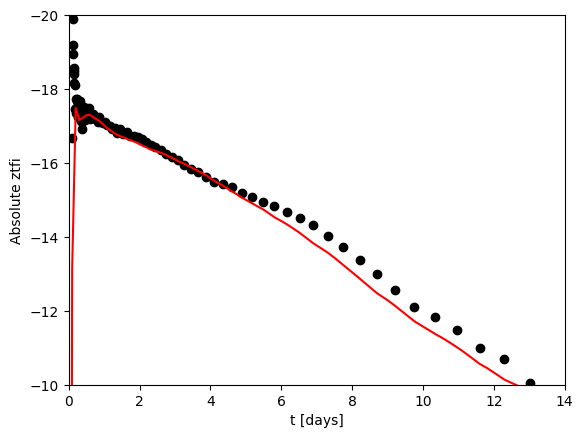

In [55]:
plt.scatter(example_training_data["t"], example_training_data["ztfi"], color='black')
plt.ylim(-10,-20)
plt.xlabel("t [days]")
plt.ylabel(f"Absolute {filt}")

plt.plot(sample_times, altmaginterp, color='red') 
plt.xlim(0,14)